In [538]:
import pandas as pd
import numpy as np
from plotnine import *
pd.set_option('display.max_columns', None)

### Notes:

1. Some counties are having a mismatch in names. Need to manually resolve the name mismatch. Only with Opioid Shipment dataset. 

##### Final Report Structure

1. Intro - High Level <br>
2. Background - High Level <br>
3. EDA - Below<br>
4. Model ?? <br>
5. Results Findings on the diff-diff and pre-post plots. <br>
6. Conclusion Policy implementation effects summary <br>

For EDA, we can plot mortality rate and analyze trends across counties in target states. <br>
For EDA, we can also plot opioid shipment and analyze trends across counties in target states.

##### Open Questions
1. Do we need to create 2 drafts?
2. Do we need to merge opioid shipment data with drug mortality data.

### Import Mortality Dataset

In [551]:
mortality = pd.read_csv('../20_intermediate_files/mortality_non_aggregated.csv')
mortality = mortality.drop('Unnamed: 0', axis =1)

In [552]:
mortality.loc[mortality['State'] == 'AL', 'STATE'] = 'Alabama'
mortality.loc[mortality['State'] == 'FL', 'STATE'] = 'Florida'
mortality.loc[mortality['State'] == 'SC', 'STATE'] = 'South Carolina'
mortality.loc[mortality['State'] == 'GA', 'STATE'] = 'Georgia'
mortality.loc[mortality['State'] == 'TX', 'STATE'] = 'Texas'
mortality.loc[mortality['State'] == 'OK', 'STATE'] = 'Oklahoma'
mortality.loc[mortality['State'] == 'WA', 'STATE'] = 'Washington'
mortality.loc[mortality['State'] == 'NC', 'STATE'] = 'North Carolina'
mortality.loc[mortality['State'] == 'CO', 'STATE'] = 'Colorado'
mortality.loc[mortality['State'] == 'AZ', 'STATE'] = 'Arizona'
mortality.loc[mortality['State'] == 'CA', 'STATE'] = 'California'
mortality.loc[mortality['State'] == 'UT', 'STATE'] = 'Utah'

StateL = ['Florida', 'Alabama', 'South Carolina', 'Georgia', 'Texas', 'Arizona', 
          'California', 'Oklahoma','Washington','North Carolina','Utah','Colorado']


In [553]:
mortality = mortality[mortality['STATE'].isin(StateL)]
mortality.columns = ['YEAR', 'State_Abrv', 'COUNTY', 'DEATHS', 'STATE']
mortality['YEAR'] = mortality['YEAR'].astype(int)

In [554]:
mortality.head()

,YEAR,State_Abrv,COUNTY,DEATHS,STATE
20,2003,CO,Adams County,42.0,Colorado
21,2004,CO,Adams County,46.0,Colorado
22,2005,CO,Adams County,63.0,Colorado
23,2006,CO,Adams County,62.0,Colorado
24,2007,CO,Adams County,70.0,Colorado


### Import Population Dataset

In [555]:
pop_2000_to_2010 = pd.read_csv('../00_source/co-est00int-tot.csv', encoding='latin-1')
pop_2000_to_2010 = pop_2000_to_2010[['STNAME', 'CTYNAME',
                                    'POPESTIMATE2000', 'POPESTIMATE2001', 'POPESTIMATE2002',
                                    'POPESTIMATE2003', 'POPESTIMATE2004', 'POPESTIMATE2005',
                                    'POPESTIMATE2006', 'POPESTIMATE2007', 'POPESTIMATE2008',
                                    'POPESTIMATE2009', 'POPESTIMATE2010']]

In [556]:
pop_2000_to_2010 = pop_2000_to_2010.melt(id_vars=['STNAME', 'CTYNAME'])
pop_2000_to_2010.columns = ['STATE', 'COUNTY', 'YEAR', 'TOTAL_POP']
pop_2000_to_2010['YEAR'] = [x[-4:] for x in pop_2000_to_2010['YEAR'].tolist()]

In [557]:
pop_2010_to_2019 = pd.read_csv('../00_source/co-est2019-alldata.csv', encoding='latin-1')
pop_2010_to_2019 = pop_2010_to_2019[['STNAME', 'CTYNAME', 'POPESTIMATE2011',
                                    'POPESTIMATE2012', 'POPESTIMATE2013', 'POPESTIMATE2014',
                                    'POPESTIMATE2015', 'POPESTIMATE2016', 'POPESTIMATE2017',
                                    'POPESTIMATE2018', 'POPESTIMATE2019']]

In [558]:
pop_2010_to_2019 = pop_2010_to_2019.melt(id_vars=['STNAME', 'CTYNAME'])
pop_2010_to_2019.columns = ['STATE', 'COUNTY', 'YEAR', 'TOTAL_POP']
pop_2010_to_2019['YEAR'] = [x[-4:] for x in pop_2010_to_2019['YEAR'].tolist()]

In [559]:
pop_df = pop_2000_to_2010.append(pop_2010_to_2019)
pop_df = pop_df.sort_values(['YEAR', 'STATE', 'COUNTY'])
pop_df = pop_df.reset_index(drop=True)
pop_df['YEAR'] = pop_df['YEAR'].astype(int)

In [560]:
pop_df['COUNTY_Abrv'] = [x[:-7] for x in pop_df['COUNTY']]
pop_df['COUNTY_Abrv'] = pop_df['COUNTY_Abrv'].str.upper()

In [561]:
pop_df.head()

,STATE,COUNTY,YEAR,TOTAL_POP,COUNTY_Abrv
0,Alabama,Alabama,2000,4452173,
1,Alabama,Autauga County,2000,44021,AUTAUGA
2,Alabama,Baldwin County,2000,141342,BALDWIN
3,Alabama,Barbour County,2000,29015,BARBOUR
4,Alabama,Bibb County,2000,19913,BIBB


### Merging Mortality Rate and Population Dataset

In [562]:
merge_cols = ['YEAR', 'STATE','COUNTY']
mor_pop = pd.merge(mortality,pop_df, how='inner', on=merge_cols)
mor_pop = mor_pop[['YEAR', 'STATE', 'State_Abrv', 'COUNTY', 'DEATHS', 'TOTAL_POP']]

In [568]:
mor_pop['COUNTY'] = mor_pop['COUNTY'].str.upper()
mor_pop['COUNTY_Abrv'] = [x[:-7] for x in mor_pop['COUNTY'].tolist()]

### Calculate Mortality/Deaths Per Capita

In [569]:
mor_pop['Deaths_Per_Cap'] = mor_pop['DEATHS'] / mor_pop['TOTAL_POP']

In [570]:
mor_pop.STATE.value_counts()

California        489
Florida           458
Texas             432
North Carolina    428
Georgia           308
Washington        198
South Carolina    183
Alabama           166
Oklahoma          141
Colorado          132
Arizona           106
Utah               66
Name: STATE, dtype: int64

In [571]:
treatment_list = ['FL', 'WA', 'TX']
mor_pop['treatment_status'] = 'Control'
mor_pop.loc[mor_pop['State_Abrv'].isin(treatment_list), 'treatment_status'] = 'Treatment'
mor_pop['treatment_status'] = pd.Categorical(mor_pop['treatment_status'])

In [572]:
mor_pop.head()

,YEAR,STATE,State_Abrv,COUNTY,DEATHS,TOTAL_POP,COUNTY_Abrv,Deaths_Per_Cap,treatment_status
0,2003,Colorado,CO,ADAMS COUNTY,42.0,377464,ADAMS,0.000111,Control
1,2004,Colorado,CO,ADAMS COUNTY,46.0,384809,ADAMS,0.000120,Control
2,2005,Colorado,CO,ADAMS COUNTY,63.0,395146,ADAMS,0.000159,Control
3,2006,Colorado,CO,ADAMS COUNTY,62.0,406575,ADAMS,0.000152,Control
4,2007,Colorado,CO,ADAMS COUNTY,70.0,415746,ADAMS,0.000168,Control


In [573]:
mor_pop.shape

(3107, 9)

# Opioid Shipment Analysis

### Note: 
This part only needs to be run once. The data has been extracted to a csv file for later steps

### Load Opioid Shipment Data

In [582]:
opioid_df = pd.read_csv('../00_source/opioid_chunked_source.zip')

In [583]:
opioid_df['Year'] = [str(x)[-4:] for x in opioid_df['TRANSACTION_DATE'].tolist()]
opioid_df['Year'] = opioid_df['Year'].astype(int)
opioid_df = opioid_df.drop(['TRANSACTION_DATE','Unnamed: 0','BUYER_CITY'], axis =1)
opioid_df ['DRUG_TOTAL'] = opioid_df.MME_Conversion_Factor * opioid_df.Weight_gram * 1000

In [584]:
opioid_df.columns = ['STATE', 'COUNTY', 'DRUG_NAME', 'MME_CONVERSION_FACTOR', 'WEIGHT_GRAM', 'YEAR', 'MME_SHIPPED']
opioid_df = opioid_df[['YEAR', 'STATE', 'COUNTY', 'MME_SHIPPED']]
opioid_df = opioid_df.groupby(['YEAR', 'STATE', 'COUNTY'], as_index = False).sum()

In [588]:
opioid_df.columns = ['YEAR', 'State_Abrv', 'COUNTY_Abrv', 'MME_SHIPPED']

opioid_df.loc[opioid_df['State_Abrv'] == 'FL', 'STATE'] = 'Florida'
opioid_df.loc[opioid_df['State_Abrv'] == 'AL', 'STATE'] = 'Alabama'
opioid_df.loc[opioid_df['State_Abrv'] == 'SC', 'STATE'] = 'South Carolina'
opioid_df.loc[opioid_df['State_Abrv'] == 'GA', 'STATE'] = 'Georgia'
opioid_df.loc[opioid_df['State_Abrv'] == 'TX', 'STATE'] = 'Texas'
opioid_df.loc[opioid_df['State_Abrv'] == 'AZ', 'STATE'] = 'Arizona'
opioid_df.loc[opioid_df['State_Abrv'] == 'CA', 'STATE'] = 'California'
opioid_df.loc[opioid_df['State_Abrv'] == 'OK', 'STATE'] = 'Oklahoma'
opioid_df.loc[opioid_df['State_Abrv'] == 'WA', 'STATE'] = 'Washington'
opioid_df.loc[opioid_df['State_Abrv'] == 'NC', 'STATE'] = 'North Carolina'
opioid_df.loc[opioid_df['State_Abrv'] == 'UT', 'STATE'] = 'Utah'
opioid_df.loc[opioid_df['State_Abrv'] == 'CO', 'STATE'] = 'Colorado'

In [589]:
treatment_list = ['FL', 'WA', 'TX']
opioid_df['treatment_status'] = 'Control'
opioid_df.loc[opioid_df['State_Abrv'].isin(treatment_list), 'treatment_status'] = 'Treatment'
opioid_df['treatment_status'] = pd.Categorical(opioid_df['treatment_status'])

In [590]:
opioid_df.head()

,YEAR,State_Abrv,COUNTY_Abrv,MME_SHIPPED,STATE,treatment_status
0,2006,AL,AUTAUGA,1.710054e+07,Alabama,Control
1,2006,AL,BALDWIN,5.103983e+07,Alabama,Control
2,2006,AL,BARBOUR,5.764019e+06,Alabama,Control
3,2006,AL,BIBB,6.278097e+06,Alabama,Control
4,2006,AL,BLOUNT,1.041747e+07,Alabama,Control


In [592]:
opioid_df.to_csv('../20_intermediate_files/opioid_shipment_extract.csv')

### Subset to Florida and its Reference States (for now)

In [599]:
opioid_df = pd.read_csv('../20_intermediate_files/opioid_shipment_extract.csv')
opioid_df = opioid_df.drop('Unnamed: 0', axis=1)

In [600]:
opioid_df = opioid_df[opioid_df['State_Abrv'].isin(['FL', 'AL', 'SC', 'GA'])]

### Merge Opioid Shipment data with Population data

In [601]:
merge_list = ['YEAR', 'STATE', 'COUNTY_Abrv']
op_pop = pd.merge(opioid_df, pop_df, how='inner', indicator = True, on=merge_list)

In [602]:
opioid_df.shape

(2320, 6)

In [603]:
op_pop.shape

(2285, 9)

In [604]:
op_pop.head()

,YEAR,State_Abrv,COUNTY_Abrv,MME_SHIPPED,STATE,treatment_status,COUNTY,TOTAL_POP,_merge
0,2006,AL,AUTAUGA,1.710054e+07,Alabama,Control,Autauga County,51328,both
1,2006,AL,BALDWIN,5.103983e+07,Alabama,Control,Baldwin County,168121,both
2,2006,AL,BARBOUR,5.764019e+06,Alabama,Control,Barbour County,27861,both
3,2006,AL,BIBB,6.278097e+06,Alabama,Control,Bibb County,22099,both
4,2006,AL,BLOUNT,1.041747e+07,Alabama,Control,Blount County,55485,both


# Diff in Diff Plot

In [605]:
def diff_in_diff_plot(df_treatment, df_control, policy_implementation_year, resp_variable):
    
    df_treatment['standardized_year'] = df_treatment['YEAR'] - policy_implementation_year
    df_control['standardized_year'] = df_control['YEAR'] - policy_implementation_year
    
    lower_lim = df_treatment['standardized_year'].min()
    upper_lim = df_treatment['standardized_year'].max()
    
    plot = (
    ggplot() +
    geom_smooth(df_treatment[df_treatment['standardized_year'] < 0], 
                aes(x='standardized_year', y=resp_variable, color='treatment_status'), method='lm') + 
    geom_smooth(df_treatment[df_treatment['standardized_year'] >= 0], 
                aes(x='standardized_year', y=resp_variable, color='treatment_status'), method='lm') + 
        
    geom_smooth(df_control[df_control['standardized_year'] < 0], 
                aes(x='standardized_year', y=resp_variable, color='treatment_status'), method='lm') + 
    geom_smooth(df_control[df_control['standardized_year'] >= 0], 
                aes(x='standardized_year', y=resp_variable, color='treatment_status'), method='lm')
    + geom_vline(xintercept = 0) 
    + xlab('standardized_year') + ylab(resp_variable)
    + scale_x_continuous(breaks=range(lower_lim,upper_lim,1))
        
    )

    return plot

/opt/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


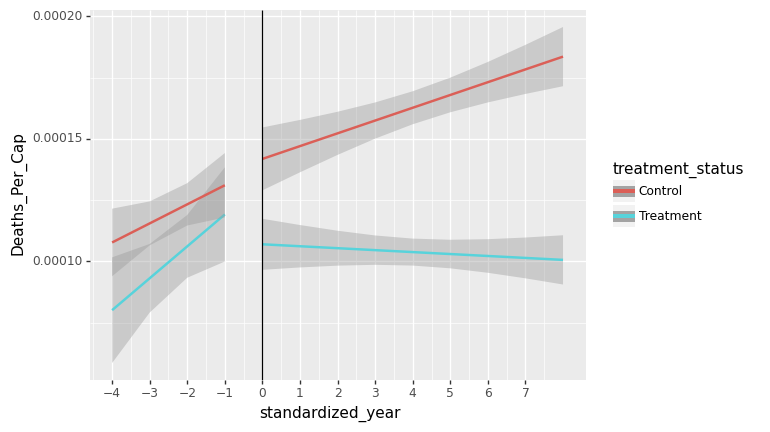

<ggplot: (8776733131517)>


In [606]:
df_treatment_TX = mor_pop[mor_pop['State_Abrv'] == 'TX'].copy()
df_control_TX = mor_pop[(mor_pop['State_Abrv'] == 'AZ') | (mor_pop['State_Abrv'] == 'CA') | (mor_pop['State_Abrv'] == 'OK')].copy()

plot = diff_in_diff_plot(df_treatment_TX, df_control_TX, policy_implementation_year_TX, 'Deaths_Per_Cap')
print(plot)

# Pre Post Plot

In [607]:
def pre_post_plot(df_treatment, policy_implementation_year, resp_variable):
    
    df_treatment['standardized_year'] = df_treatment['YEAR'] - policy_implementation_year
    
    lower_lim = df_treatment['standardized_year'].min()
    upper_lim = df_treatment['standardized_year'].max()
    
    plot = (
    ggplot() +
    geom_smooth(df_treatment[df_treatment['standardized_year'] < 0], 
                aes(x='standardized_year', y=resp_variable, color='treatment_status'), method='lm') + 
    geom_smooth(df_treatment[df_treatment['standardized_year'] >= 0], 
                aes(x='standardized_year', y=resp_variable, color='treatment_status'), method='lm')
        
    + geom_vline(xintercept = 0) 
    + xlab('standardized_year') + ylab(resp_variable)
    + scale_x_continuous(breaks=range(lower_lim,upper_lim,1))
        
    )

    return plot

/opt/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


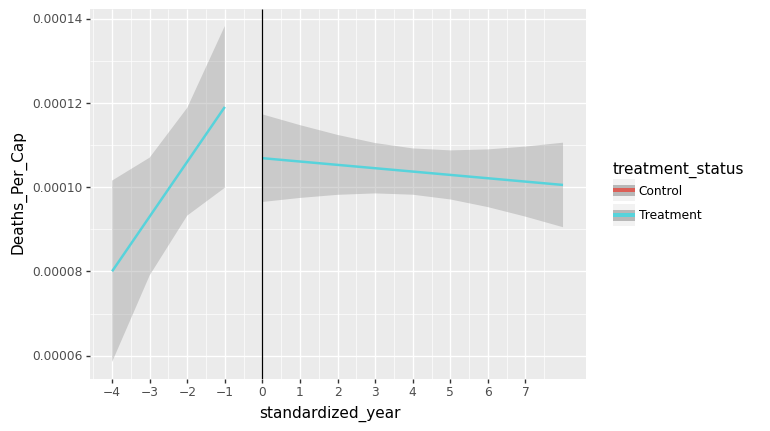

<ggplot: (8776047785991)>


In [608]:
df_treatment_TX = mor_pop[mor_pop['State_Abrv'] == 'TX'].copy()
df_control_TX = mor_pop[(mor_pop['State_Abrv'] == 'AZ') | (mor_pop['State_Abrv'] == 'CA') | (mor_pop['State_Abrv'] == 'OK')].copy()

plot = pre_post_plot(df_treatment_TX, policy_implementation_year_TX, 'Deaths_Per_Cap')
print(plot)